In [107]:
from transformers import AutoTokenizer,AutoModel
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Loading Credentials
with open("credentials.yaml", 'r') as stream:
    credentials = yaml.safe_load(stream)

## Pulling Model from huggingface Repo

In [192]:
#First, tried AutoModel, since that was what searches for how to infer for T5 model lead me to:

#tokenizer = AutoTokenizer.from_pretrained("roivian/manningLp")
#model = AutoModel.from_pretrained("roivian/manningLp")


In [193]:
# After getting some issues with the AutoModel, used additional ManningLP resources
# so loading model the following way:

from transformers.models.t5 import T5ForConditionalGeneration, T5Tokenizer
model = T5ForConditionalGeneration.from_pretrained("roivian/manningLp")
tokenizer = T5Tokenizer.from_pretrained("roivian/manningLp")

## Infering Unlabeled Dataset

In [13]:
data = pd.read_csv("unlabelled_df.csv")

In [14]:
data.head(5)

,submission_id,submission_title,submission_selftext,submission_link_flair_text,reply_body,all_text,reply_body_list
0,aglcrj,Goodnotes 4 vs. Goodnotes 5 right now,I have used Goodnotes 4 for work a ton. And I...,NaN,"[""I'm getting a ton of bugs with 5 as well (sn...",Goodnotes 4 vs. Goodnotes 5 right now I have u...,"[""I'm getting a ton of bugs with 5 as well (sn..."
1,agoowm,The bundle is available !,NaN,NaN,['Thank you. I have been waiting!\n\n&amp;#x20...,The bundle is available ! Thank you. I have b...,['Thank you. I have been waiting!\n\n&amp;#x20...
2,agpzxb,What happened to the pen (Goodnotes 5)?,I just got Goodnotes 5 and I was so excited fo...,NaN,"[""Have you tried the ball pen? That was the cl...",What happened to the pen (Goodnotes 5)? I just...,"[""Have you tried the ball pen? That was the cl..."
3,agq8qv,Non Apple Pencil styluses on GOodnotes 5?,I've been using a Wacom Bamboo stylus with Goo...,NaN,['According to the [review at Macstories](http...,Non Apple Pencil styluses on GOodnotes 5? I've...,['According to the [review at Macstories](http...
4,agqksi,Text/typing in Goodnotes 5,"Notability user here, but trying out Goodnotes...",NaN,"[""That's neat af"", 'Seattle, hopefully not too...",Text/typing in Goodnotes 5 Notability user her...,"[""That's neat af"", 'Seattle, hopefully not too..."


In [43]:
# With Help from ManningLP

In [84]:
def infer(to_predict):
    
    # Encoding
    input_batch = tokenizer(to_predict,
                padding=True,
                truncation=True,
                return_tensors='pt',
                max_length=400)
    input_ids = input_batch["input_ids"]
    attention_mask = input_batch["attention_mask"]
    
    # Predicting
    prediction = model.generate(input_ids=input_ids,
            attention_mask=attention_mask,
            num_beams=4,
            max_length=300,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            num_return_sequences=1)
    
    # Decoding Prediction
    return [tokenizer.decode(x, skip_special_tokens=True) for x in prediction]
    

In [87]:
tag_prefix = ""#used empty string for my locally trained model
title_prefix = 'title prediction'

In [88]:
# Validating on Smaller number of data

X = list(tag_prefix+": "+data['all_text'][0:2])
infer(X)

['Question', 'Question']

In [89]:
X = list(title_prefix+": "+data['all_text'][0:2])
infer(X)

['Question about use with Goodnotes 5 and Supernotes 5',
 'I’m having trouble with creating digests in my PDFs every time.']

#### Infering for the entire unlabeled dataset

In [90]:
to_predict = [
    tag_prefix + ": " + str(input_text)
    for input_text in data["all_text"].tolist()
]

In [92]:
data['inferred_flair_text']=infer(to_predict)

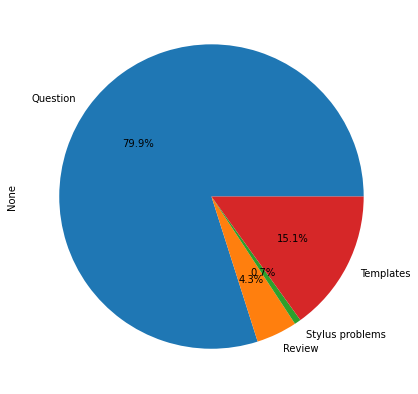

In [111]:
fig=plt.figure(figsize=(7,7))
data[['inferred_flair_text']].groupby(by="inferred_flair_text").size().plot.pie(autopct="%.1f%%");

#### Manually labeling some reviews

In [127]:
data['manual_label'] = ''

In [188]:
i = 72

In [189]:
i+=1
sample = data.iloc[i]
print("Title:",sample['submission_title'])
print()
print("Body:", sample['submission_selftext'])
print()
print("Comments:", sample['reply_body_list'])

Title: Chalkboard like?

Body: Is there any kind of setting or customization to make GoodNotes 
look like a chalkboard and chalk-like pen?

Comments: ['Nope', 'keynote has a great chalklike template', 'The best recommendation I have is to download a dark/chalkboard template; GoodNotes manages a Dropbox folder that includes said templates and can be subscribed to [here](https://support.goodnotes.com/hc/en-us/articles/115003609803-How-can-I-get-more-templates-for-GoodNotes-). You can then import the template into GoodNotes and use a white pen/marker to give it a chalkboard look.', 'There’s a chalkboard font, if you don’t mind typing instead of writing with the pen.', "Just not sure why you would want to do this, but you can do it in Procreate if that's what you want to do.", 'This is what I do, I created a PDF of various chalkboard backgrounds that I imported.  I tend to just use the pen but there is also a chalkboard font by apple you can use with the text tool.  Theres three, then I ca

In [190]:
data.at[i,'manual_label']='Question'

In [191]:
data[data['manual_label']!=''][['inferred_flair_text','manual_label']]

,inferred_flair_text,manual_label
0,Question,Problems
1,Question,N/A
2,Question,Question
3,Question,Question
4,Question,Question
5,Question,Question
6,Question,Question
7,Question,Question
12,Templates,Templates
32,Templates,Templates


After manually labeling some of the unlabeled data, model seemed to do a decent job forecasting for different classes!
Some topics that do not fall to any of the categories were categorized as Question, but that's understandable since Model can chose between options it is awared of. But overally pretty impressive!